<a href="https://colab.research.google.com/github/aureliodeboa/Calculo-Numerico/blob/main/Numerico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **Calculo numérico**

---



# **Bibliotecas e Banco de dados**

Adiciona bibliotecas, puxa os dados do banco, seleciona a cidade desejada no ano de 2022 e seleciona apenas as colunas: **novos novos casos** e **numero total de casos**




In [1]:
import pandas as pd # dataframes
import matplotlib.pyplot as plt # plotting data
# import gzip file with cities data

df_cities = pd.read_csv("https://github.com/wcota/covid19br/blob/master/cases-brazil-cities-time_2022.csv.gz?raw=true", compression='gzip')

#df_campo = df_cities.loc[df_cities['city']=='Campo Formoso/BA' ,'totalCases']
df_cities["date"] = pd.to_datetime(df_cities["date"])
df = df_cities[df_cities['city']=='Juazeiro/BA'] # escolhe a cidade
df = df[["date","newCases","totalCases"]] # get data, newCases e Total cases
df.reset_index(inplace=True, drop=True)   #reseto os index do df pois estavam bugados
#df_campo[df_campo["date"].dt.year == 2022]  # os dados já são desse periodo mes1 ao mes 12

print(df)

          date  newCases  totalCases
0   2022-01-01         2       19470
1   2022-01-02         1       19471
2   2022-01-03         4       19475
3   2022-01-04        56       19531
4   2022-01-05        27       19558
..         ...       ...         ...
360 2022-12-27        71       28979
361 2022-12-28        54       29033
362 2022-12-29        28       29061
363 2022-12-30        57       29118
364 2022-12-31         0       29118

[365 rows x 3 columns]


**CALCULO DA MEDIA MOVEL DE 7 DIAS**

In [2]:
#from datetime import datetime, timedelta
df_media = pd.DataFrame() #cria um data frame vazio para guarda as medias de 7 dias
df_media = pd.DataFrame(df_media, columns=['date', 'media7'])  #defino a primeira coluna como data e a segunda como a media dos 7 dias anteriores
df_media["date"] = pd.to_datetime(df_media["date"])    # defino a coluna date como date time

#df2= df.set_index('date')
#df_media= df_media.set_index('date')
#print(df.iloc[0].date - timedelta(days=7)) #tava testando
#print(df2.loc[df.iloc[7].date - timedelta(days=7)].newCases) #tava testando

media=0 #variavel que acumula o numero de casos

for i in df.itertuples():  #percorro todos os dados para pode calcular a media
  media+=i.newCases       #media igual a media anterior o numero de casos atual
  if( i.date.day >= 7):   #esse if é para cacular a media movel apartir do 7 dia util do ano
   df_media.loc[len(df_media)]= [i.date, (media/7.0)]   #adciono o valor da media/7 no df das medias junto com a respectiva data
   media-= df.loc[i.Index-6].newCases              # tiro do acumulador o numero de casos de 7 dias atras para preservar a janela de 7 dias

#df_media
df.head(3)

,date,newCases,totalCases
0,2022-01-01,2,19470
1,2022-01-02,1,19471
2,2022-01-03,4,19475


**Depois achei essa função que faz todo meu trabalho de 8 horas em uma linha (CALCULO DA MEDIA MOVEL DE 7 DIAS E O GRAFICO)**


<Axes: xlabel='date'>

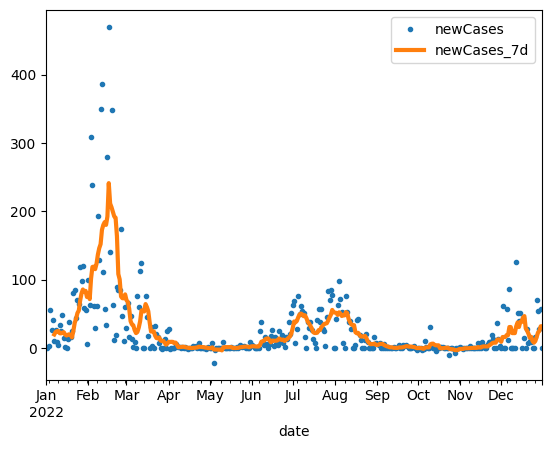

In [3]:

#df.plot(x="date",y="newCases")
#df_media.plot(x="date", y="media7")
ax = plt.gca()

_df = df
_df["newCases_7d"] = df["newCases"].rolling(7).mean() #ESSA LINHA VALE MILHOES
_df.plot(x = "date", y="newCases",marker=".",lw=0, ax=ax)
_df.plot(x = "date", y="newCases_7d",ax=ax,lw=3)

# **Metodo dos minimos quardrados para prever a quantidade de casos**

In [14]:
from pandas._libs.tslibs import timestamps
import numpy as np



_df['day'] =_df['date'].dt.day
_df['g1'] = _df['date'].dt.day * _df['date'].dt.day
_df['g2'] = _df['date'].dt.day
_df['y'] =   _df['newCases']
_df['previsao']= np.nan
_df['erro_relativo']= np.nan



g3= np.ones(21) # nem precisava disso
g1g1 = g1g2 = g1g3 = g2g3 = g3g3 = yg1 = yg2 = yg3= g2g2 = g3g3 = 0 #serão  os valores da matriz 3x3

for i in _df.itertuples():
  #acumula os valores moveis de 21 dias dos G's e dos YG's
 g1g1+= i.g1*i.g1
 g1g2+= i.g1*i.g2
 g1g3+= i.g1*g3[1]
 g2g2+= i.g2*i.g2
 g2g3+= i.g2*g3[1]
 g3g3+= g3[1]*g3[1]
 yg1+=  i.g1*i.y
 yg2+=  i.g2*i.y
 yg3+=  i.y*g3[1]

 # quando passar dos 21 dias, ira calcular o dia 21
 if(i.day > 21):

  A= np.array([[g1g1, g1g2,g1g3],[g1g2,g2g2,g2g3],[g1g3,g2g3,g3g3]])
  b= np.array([[yg1],[yg2],[yg3]])

  funcEstimativa = np.linalg.solve(A,b) #resolve o sistema linear
  previsao = (i.day**2)*(funcEstimativa[0]) + i.day*(funcEstimativa[1])+ (funcEstimativa[2]) #calcula apartir da função o valor estimado 'a previsão'
  if(i.newCases):
    erro_relativo = abs((previsao - i.newCases)/i.newCases)
  else:
   erro_relativo= abs((previsao - i.newCases)/previsao)
   #divisao por zero tratarr a if condition else b

  #tira dos aculadores o valor de 21 dias atras, para que assim a função seja baseada somente nos 21 dias anteriores
  g1g1 -= _df.loc[i.Index-21].g1 * _df.loc[i.Index-21].g1
  g1g2 -= _df.loc[i.Index-21].g1 * _df.loc[i.Index-21].g2
  g1g3 -= _df.loc[i.Index-21].g1
  g2g2 -= _df.loc[i.Index-21].g2 * _df.loc[i.Index-21].g2
  g2g3 -= _df.loc[i.Index-21].g2
  g3g3 -= 1
  yg1 -= _df.loc[i.Index-21].g1 * _df.loc[i.Index-21].y
  yg2 -=  _df.loc[i.Index-21].g2 * _df.loc[i.Index-21].y
  yg3 -= _df.loc[i.Index-21].y


  _df.iloc[[i.Index],-2]= float(previsao)
  _df.iloc[[i.Index],-1]= float(erro_relativo)
  #new_row = {'date': i.date, 'newCases': i.newCases , 'newCases_7d': i.newCases_7d, 'day': i.day, 'previsao': previsao, 'erro_relativo': 0}
  #_df.append(new_row,ignore_index=True)
  #_df.loc[i.Index].erro_relativo= ((previsao - _df.loc[i.Index].newCases)/ _df.loc[i.Index].newCases)
  #_df.loc[i.Index]['previsao'] = float(previsao)


_df


,date,newCases,totalCases,newCases_7d,day,g1,g2,y,previsao,erro_relativo
0,2022-01-01,2,19470,NaN,1,1,1,2,NaN,NaN
1,2022-01-02,1,19471,NaN,2,4,2,1,NaN,NaN
2,2022-01-03,4,19475,NaN,3,9,3,4,NaN,NaN
3,2022-01-04,56,19531,NaN,4,16,4,56,NaN,NaN
4,2022-01-05,27,19558,NaN,5,25,5,27,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
360,2022-12-27,71,28979,16.571429,27,729,27,71,19.739369,0.721981
361,2022-12-28,54,29033,23.142857,28,784,28,54,21.136027,0.608592
362,2022-12-29,28,29061,25.571429,29,841,29,28,22.484813,0.196971
363,2022-12-30,57,29118,32.285714,30,900,30,57,25.684805,0.549389


import numpy as np
from google.colab import autoviz
df_2060760211634798054 = autoviz.get_registered_df('df_2060760211634798054')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_2060760211634798054, *['newCases'], **{})
chart

import numpy as np
from google.colab import autoviz
df_2781415345497730056 = autoviz.get_registered_df('df_2781415345497730056')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_2781415345497730056, *['totalCases'], **{})
chart

import numpy as np
from google.colab import autoviz
df_8353431721748968560 = autoviz.get_registered_df('df_8353431721748968560')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_8353431721748968560, *['newCases_7d'], **{})
chart

import numpy as np
from google.colab import autoviz
df_6527246324478107802 = autoviz.get_registered_df('df_6527246324478107802')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_6527246324478107802, *['day'], **{})
chart

import numpy as np
from google.colab import autoviz
df_6782933157194292423 = autoviz.get_registered_df('df_6782933157194292423')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_6782933157194292423, *['newCases'], **{})
chart

import numpy as np
from google.colab import autoviz
df_6517800278342614535 = autoviz.get_registered_df('df_6517800278342614535')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_6517800278342614535, *['totalCases'], **{})
chart

import numpy as np
from google.colab import autoviz
df_5528663005043075236 = autoviz.get_registered_df('df_5528663005043075236')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_5528663005043075236, *['newCases_7d'], **{})
chart

import numpy as np
from google.colab import autoviz
df_3156404929563473682 = autoviz.get_registered_df('df_3156404929563473682')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_3156404929563473682, *['day'], **{})
chart

import numpy as np
from google.colab import autoviz
df_4112620619347351188 = autoviz.get_registered_df('df_4112620619347351188')

def scatter_plots(df, colname_pairs, scatter_plot_size=2.5, size=8, alpha=.6):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * scatter_plot_size, scatter_plot_size))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    ax.scatter(df[x_colname], df[y_colname], s=size, alpha=alpha)
    plt.xlabel(x_colname)
    plt.ylabel(y_colname)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df_4112620619347351188, *[[['newCases', 'totalCases'], ['totalCases', 'newCases_7d'], ['newCases_7d', 'day'], ['day', 'g1']]], **{})
chart

import numpy as np
from google.colab import autoviz
df_7298204225371539605 = autoviz.get_registered_df('df_7298204225371539605')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_7298204225371539605, *['date', 'newCases', None], **{})
chart

import numpy as np
from google.colab import autoviz
df_6199005515689517281 = autoviz.get_registered_df('df_6199005515689517281')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_6199005515689517281, *['date', 'totalCases', None], **{})
chart

import numpy as np
from google.colab import autoviz
df_4645940908177012774 = autoviz.get_registered_df('df_4645940908177012774')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_4645940908177012774, *['date', 'newCases_7d', None], **{})
chart

import numpy as np
from google.colab import autoviz
df_8394537883419618986 = autoviz.get_registered_df('df_8394537883419618986')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_8394537883419618986, *['date', 'day', None], **{})
chart